In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(patchwork)
library(stringr)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
seurat_obj_ls <- 
    lapply(c('iso-F-04','iso-F-22','iso-F-35','iso-M-00','iso-M-23','iso-M-40','soc-F-05','soc-F-24','soc-F-36','soc-M-01','soc-M-25','soc-M-41'),
       function(x){
           cell.use <- read.csv(paste0("./samples/",x,".Rat.allCells.csv"))%>% 
            filter(pass=="True") %>%
            pull(X)
        Read10X(paste0("alignment/",x,".Rat/",x,".Rat.star.solo/GeneFull_Ex50pAS/raw/")) %>%
           CreateSeuratObject(project = "Rat", min.cells = 3, min.features = 200) %>%       
            subset(cells = cell.use)
           })

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with da

In [3]:
Seurat_merged <- merge(seurat_obj_ls[[1]],seurat_obj_ls[-1],project="Rat",
                       add.cell.ids =c('iso-F-04','iso-F-22','iso-F-35','iso-M-00','iso-M-23','iso-M-40','soc-F-05','soc-F-24','soc-F-36','soc-M-01','soc-M-25','soc-M-41'))

In [4]:
Seurat_merged

An object of class Seurat 
26597 features across 76385 samples within 1 assay 
Active assay: RNA (26597 features, 0 variable features)
 12 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12

In [5]:
Seurat_merged[["RNA"]] <-JoinLayers(Seurat_merged[["RNA"]])

In [6]:
Seurat_merged

An object of class Seurat 
26597 features across 76385 samples within 1 assay 
Active assay: RNA (26597 features, 0 variable features)
 1 layer present: counts

## QC and Cell-level filtering

In [7]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
Seurat_merged[["percent.mt"]] <- PercentageFeatureSet(Seurat_merged, pattern = "^Mt-")

In [8]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

In [9]:
# Visualize QC metrics as a violin plot
p1 <- VlnPlot(Seurat_merged, features = c("nFeature_RNA", "nCount_RNA"), ncol = 3,layer='counts')

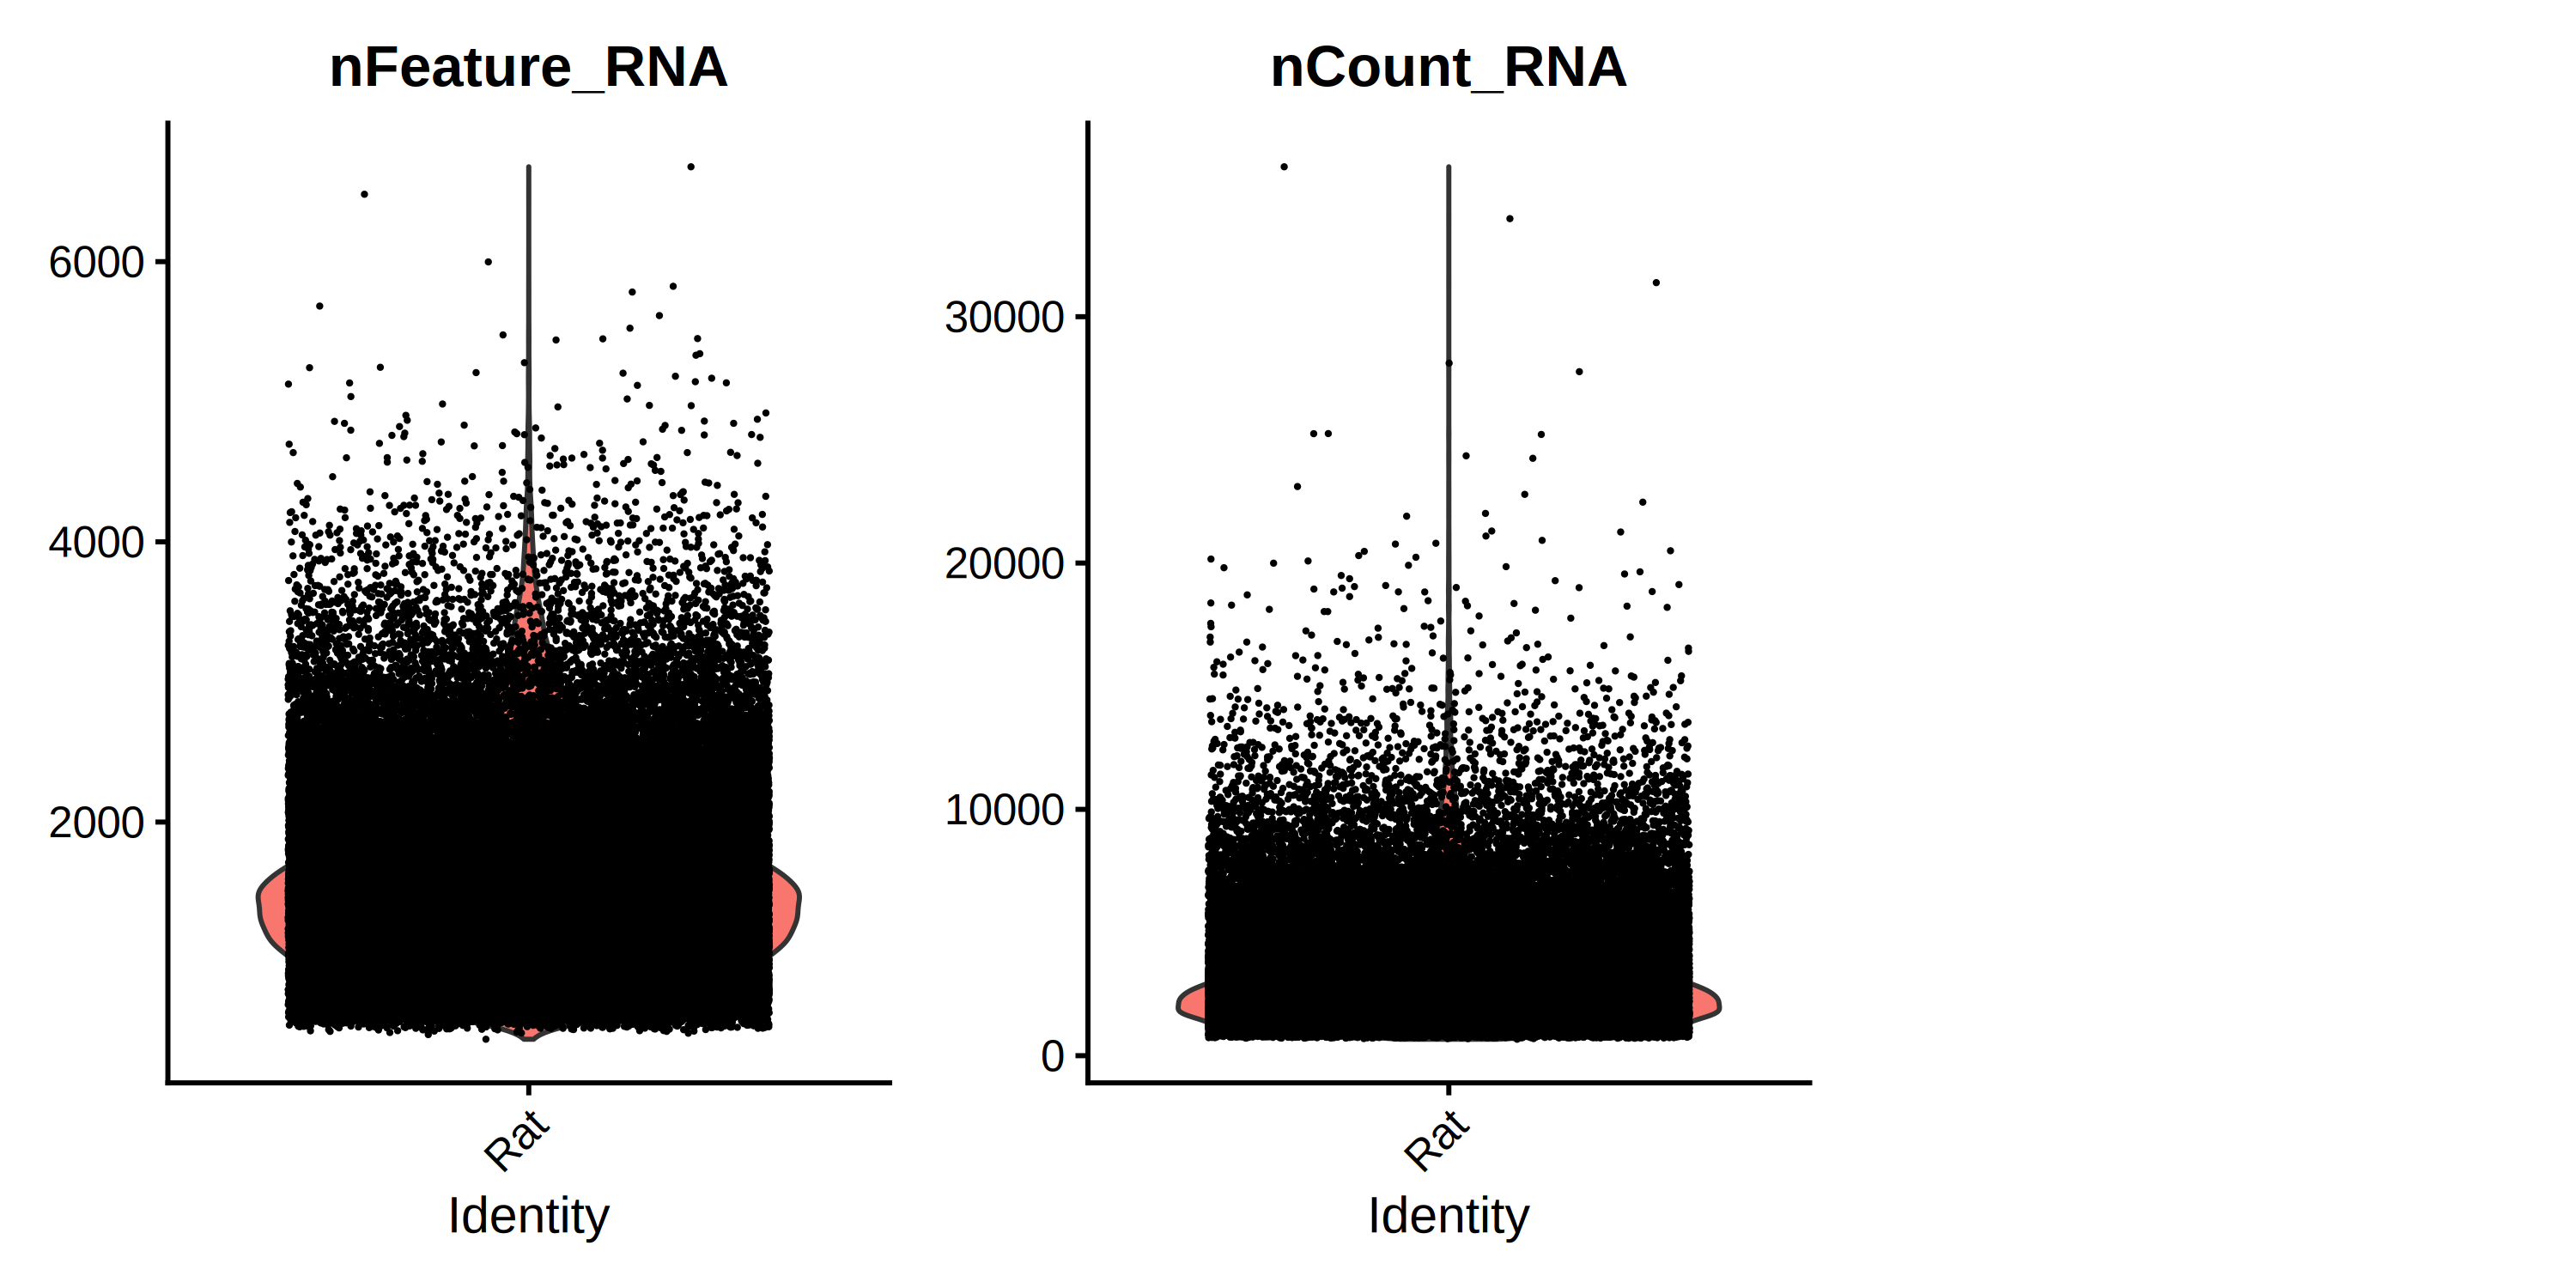

In [10]:
p1

In [11]:
obj <- subset(Seurat_merged, subset = nFeature_RNA > 200 & nFeature_RNA < 4000)

In [12]:
obj

An object of class Seurat 
26597 features across 76089 samples within 1 assay 
Active assay: RNA (26597 features, 0 variable features)
 1 layer present: counts

## Normalizing the data

In [13]:
obj <- SCTransform(obj, vst.flavor = 'v2', verbose = FALSE) 

In [14]:
obj <- obj %>%
    RunPCA(npcs = 30, verbose = FALSE,features = VariableFeatures(object = obj))

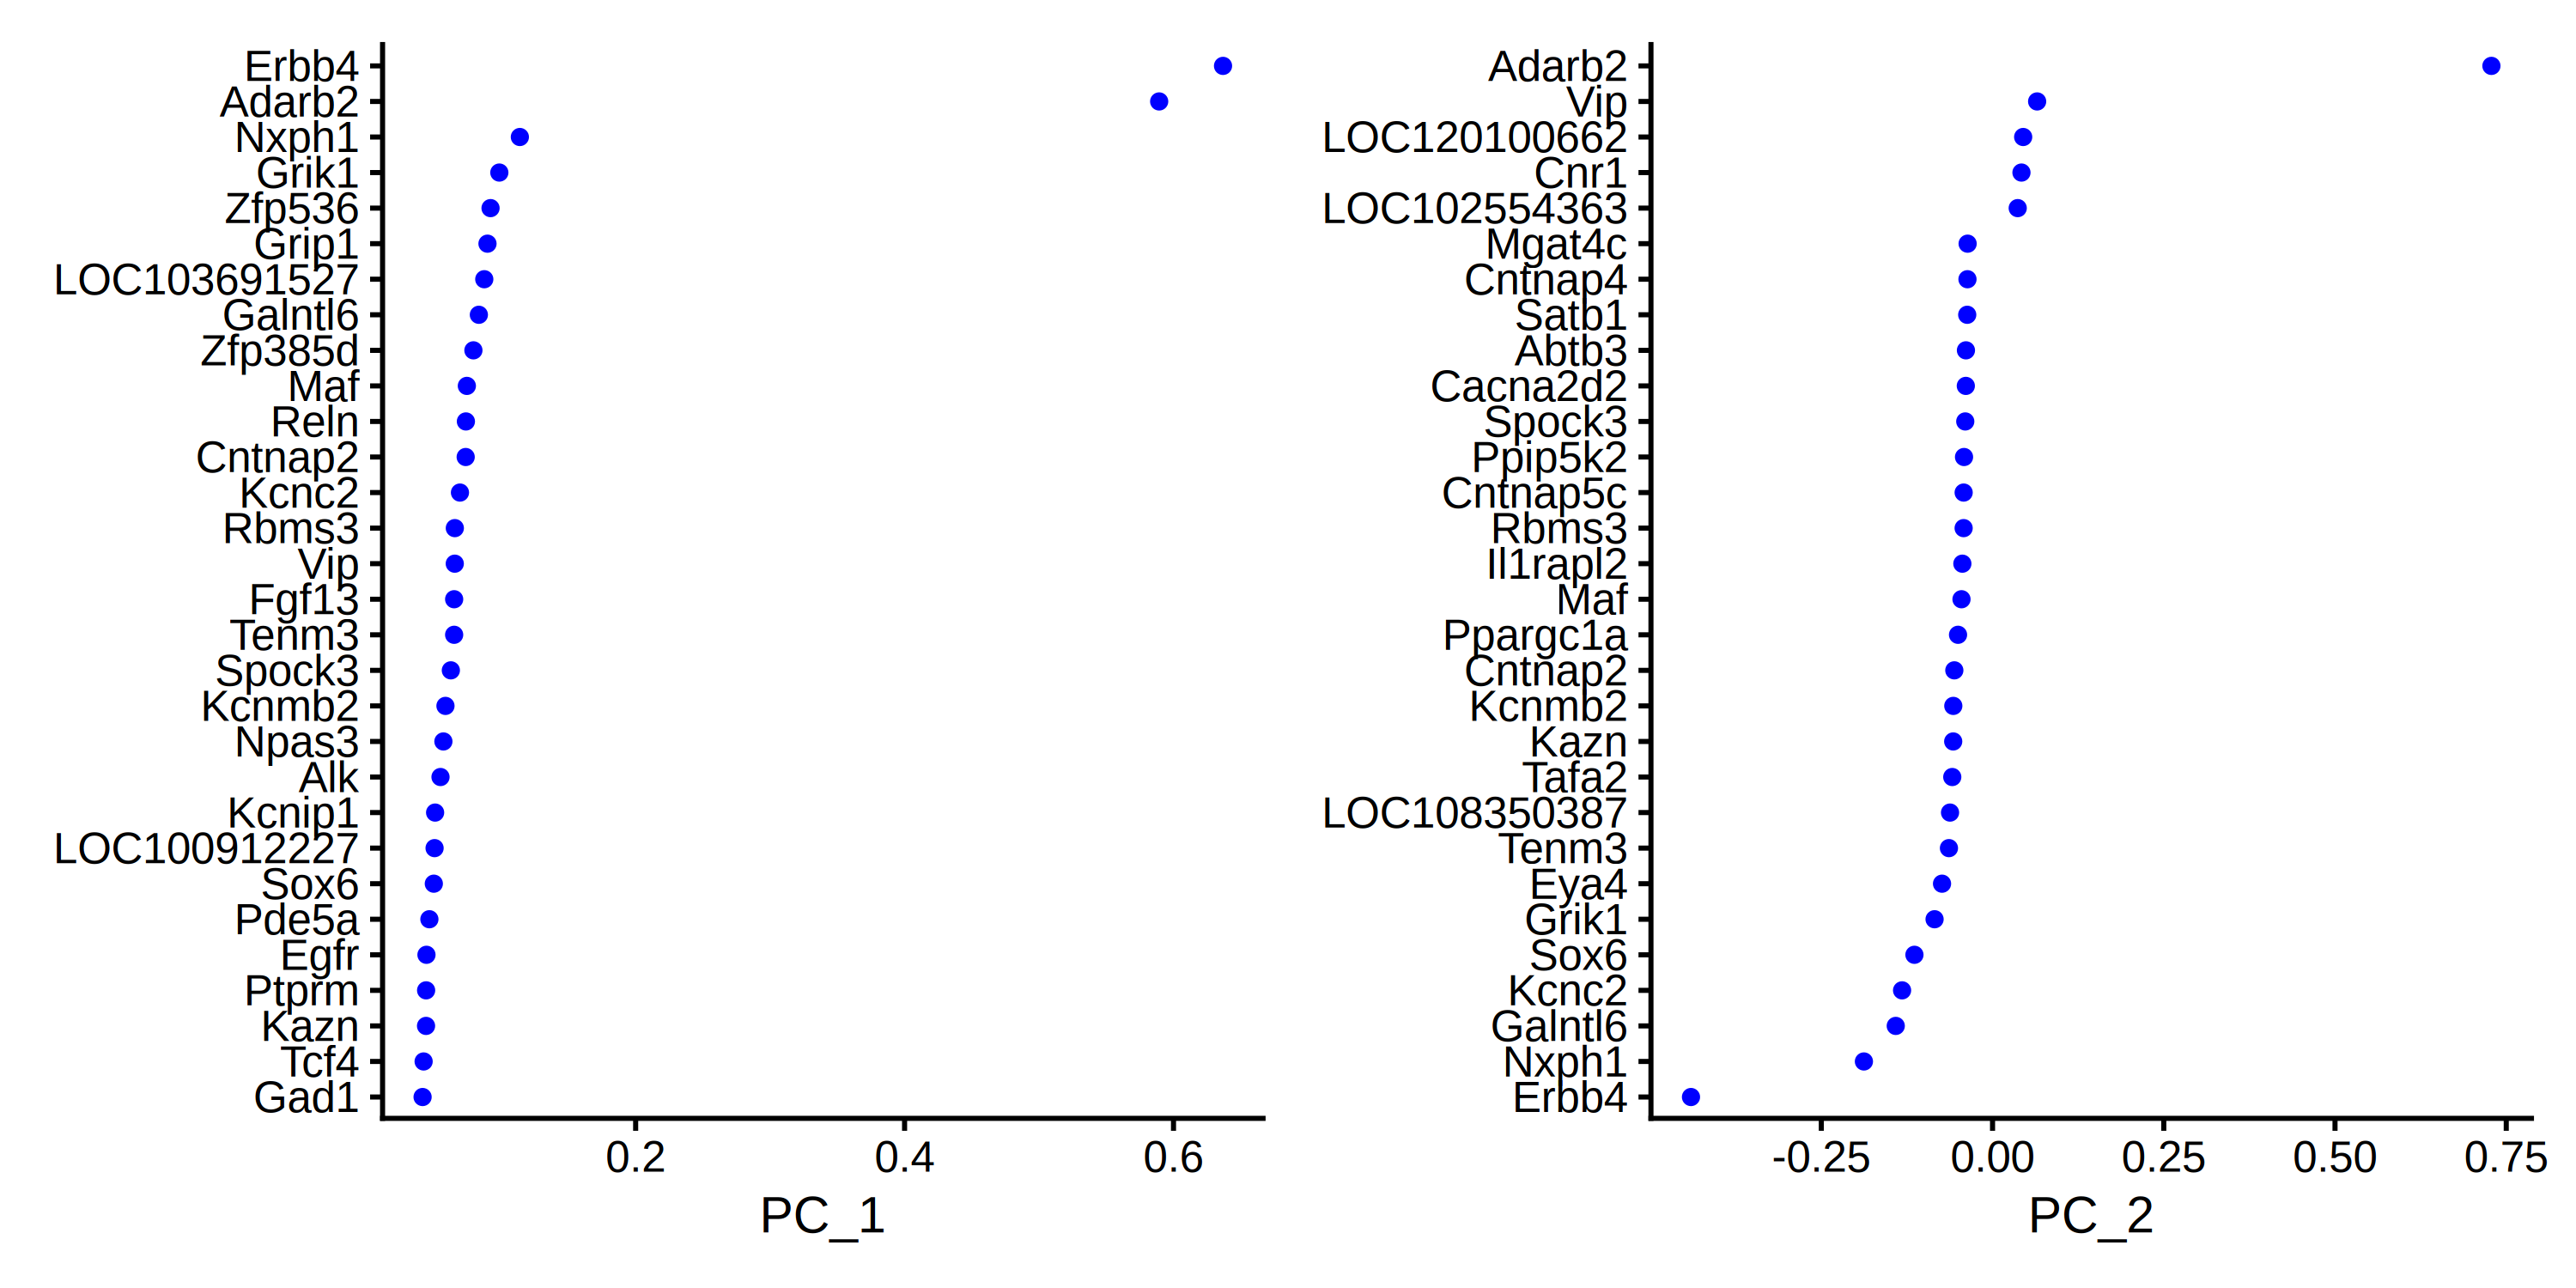

In [15]:
VizDimLoadings(obj, dims = 1:2, reduction = "pca")

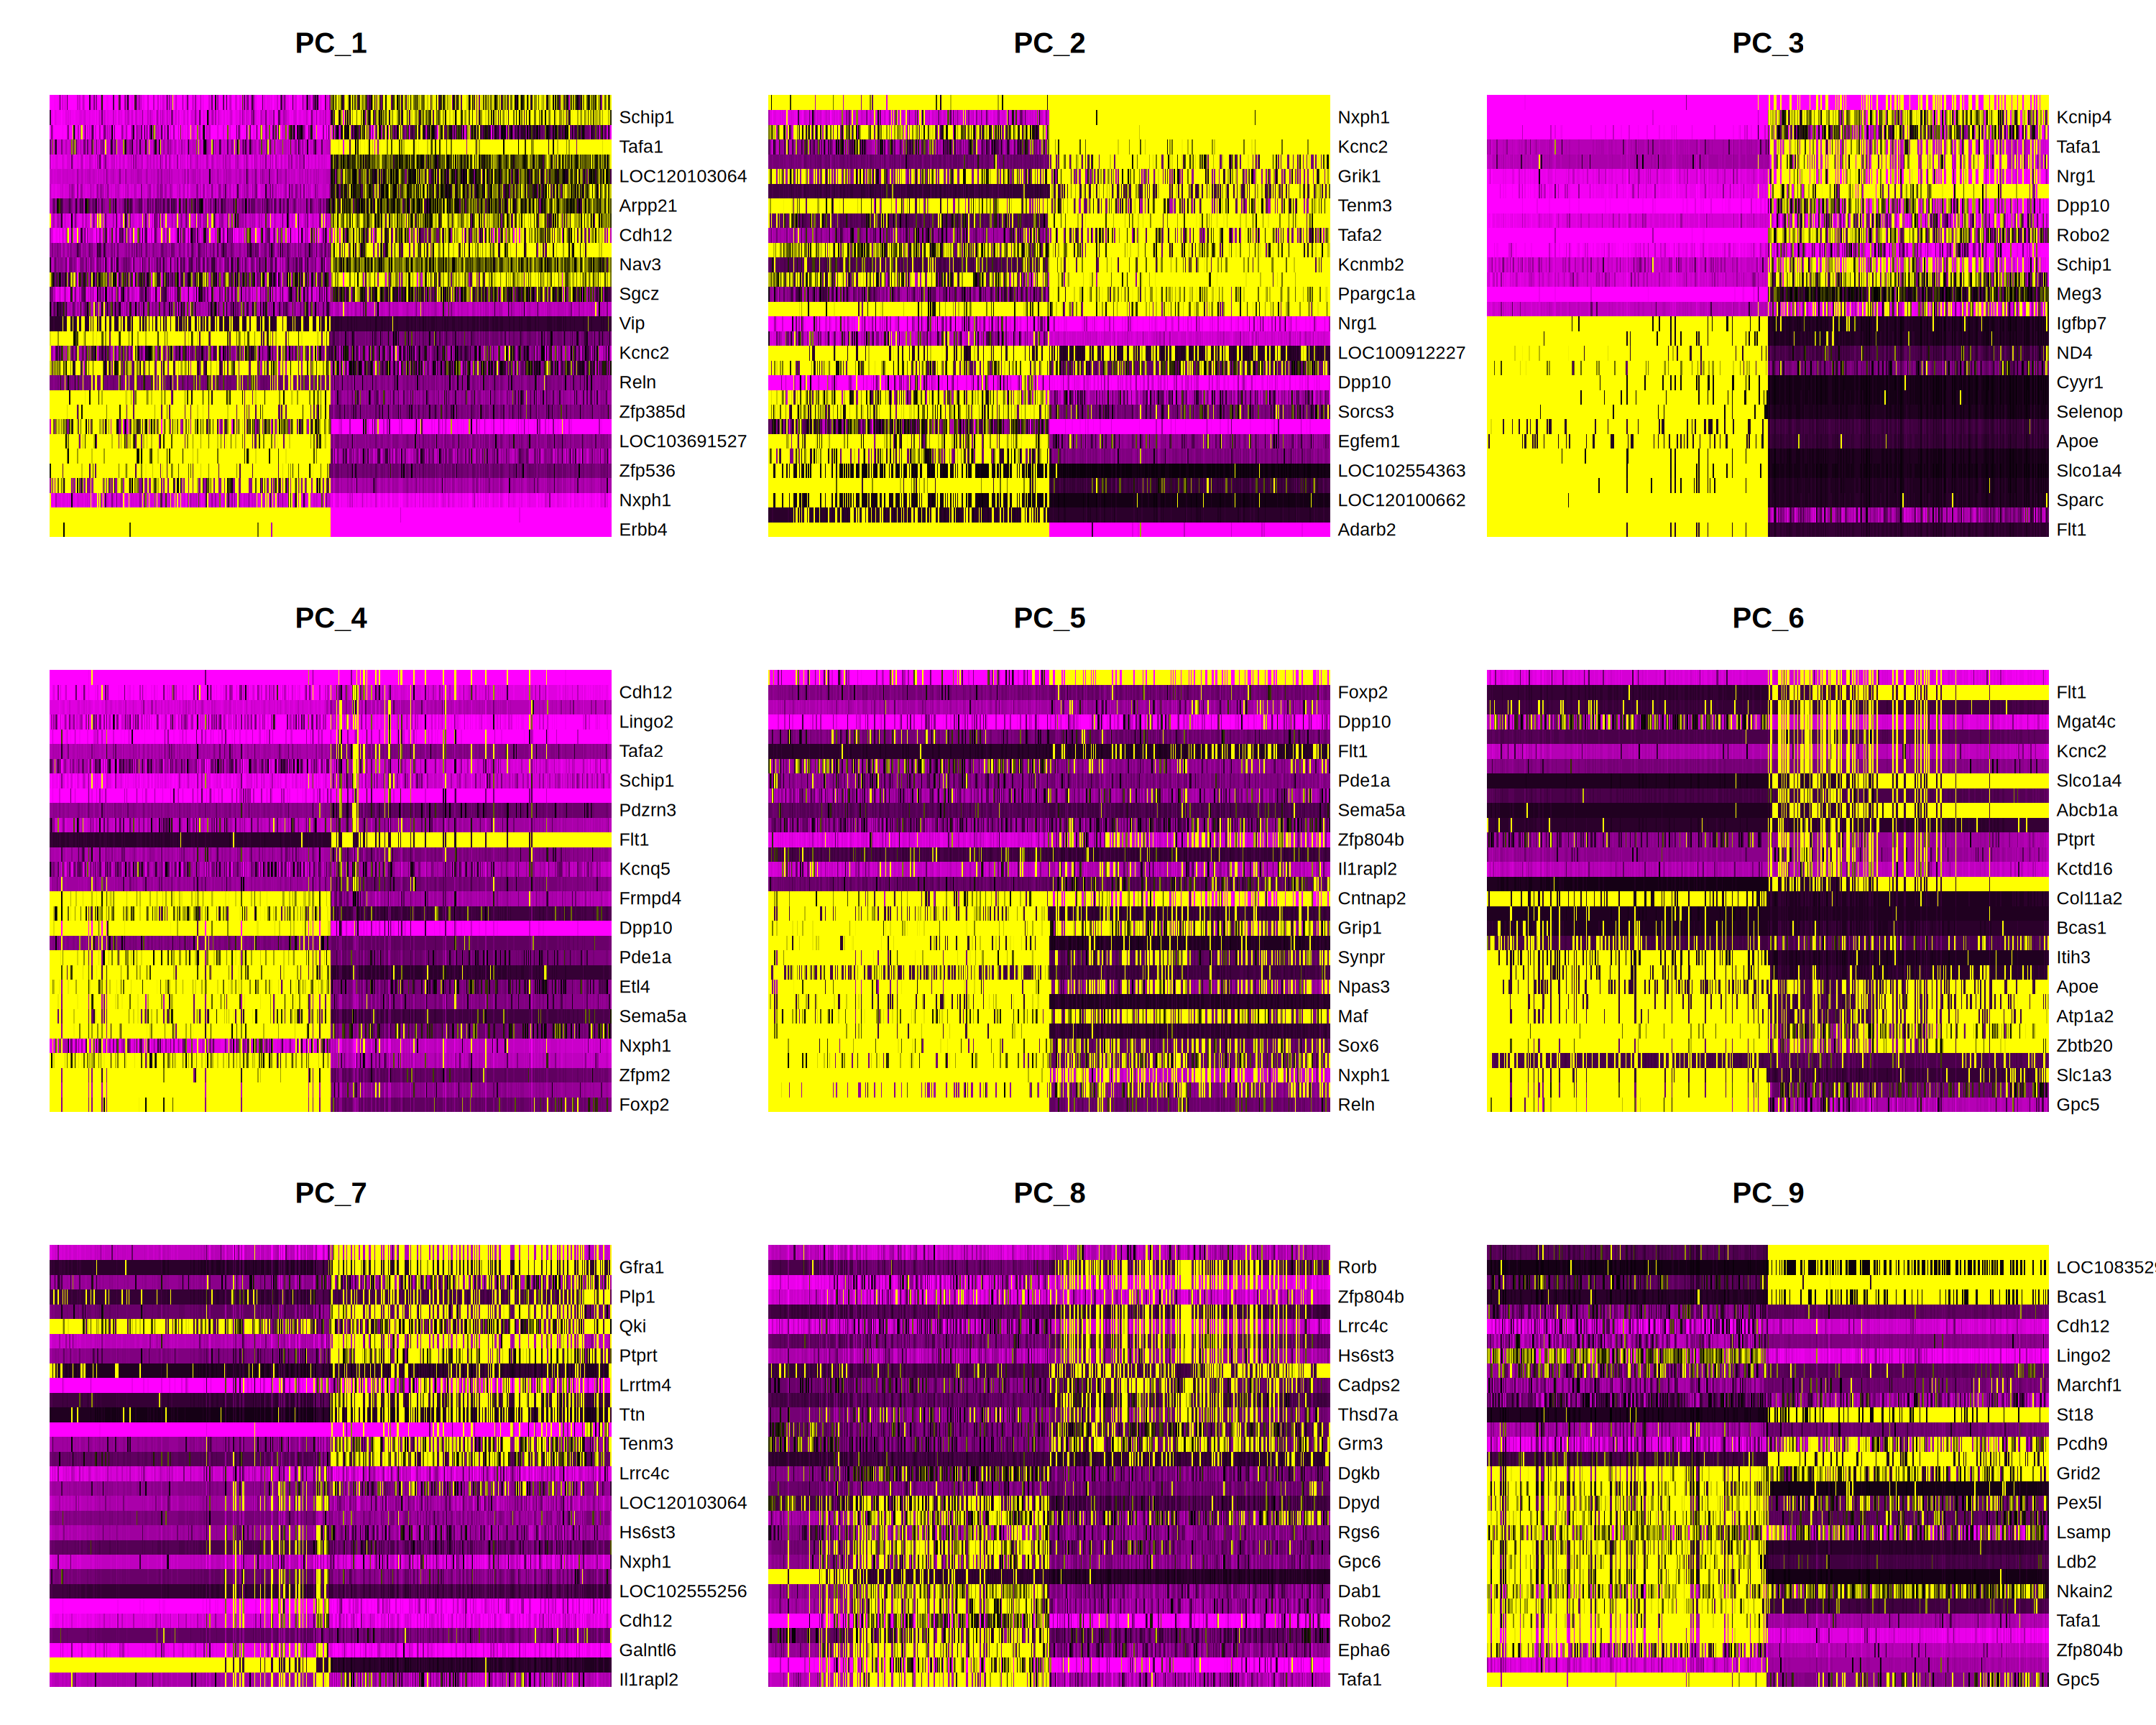

In [16]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)
DimHeatmap(obj, dims = 1:9, cells = 500, balanced = TRUE)

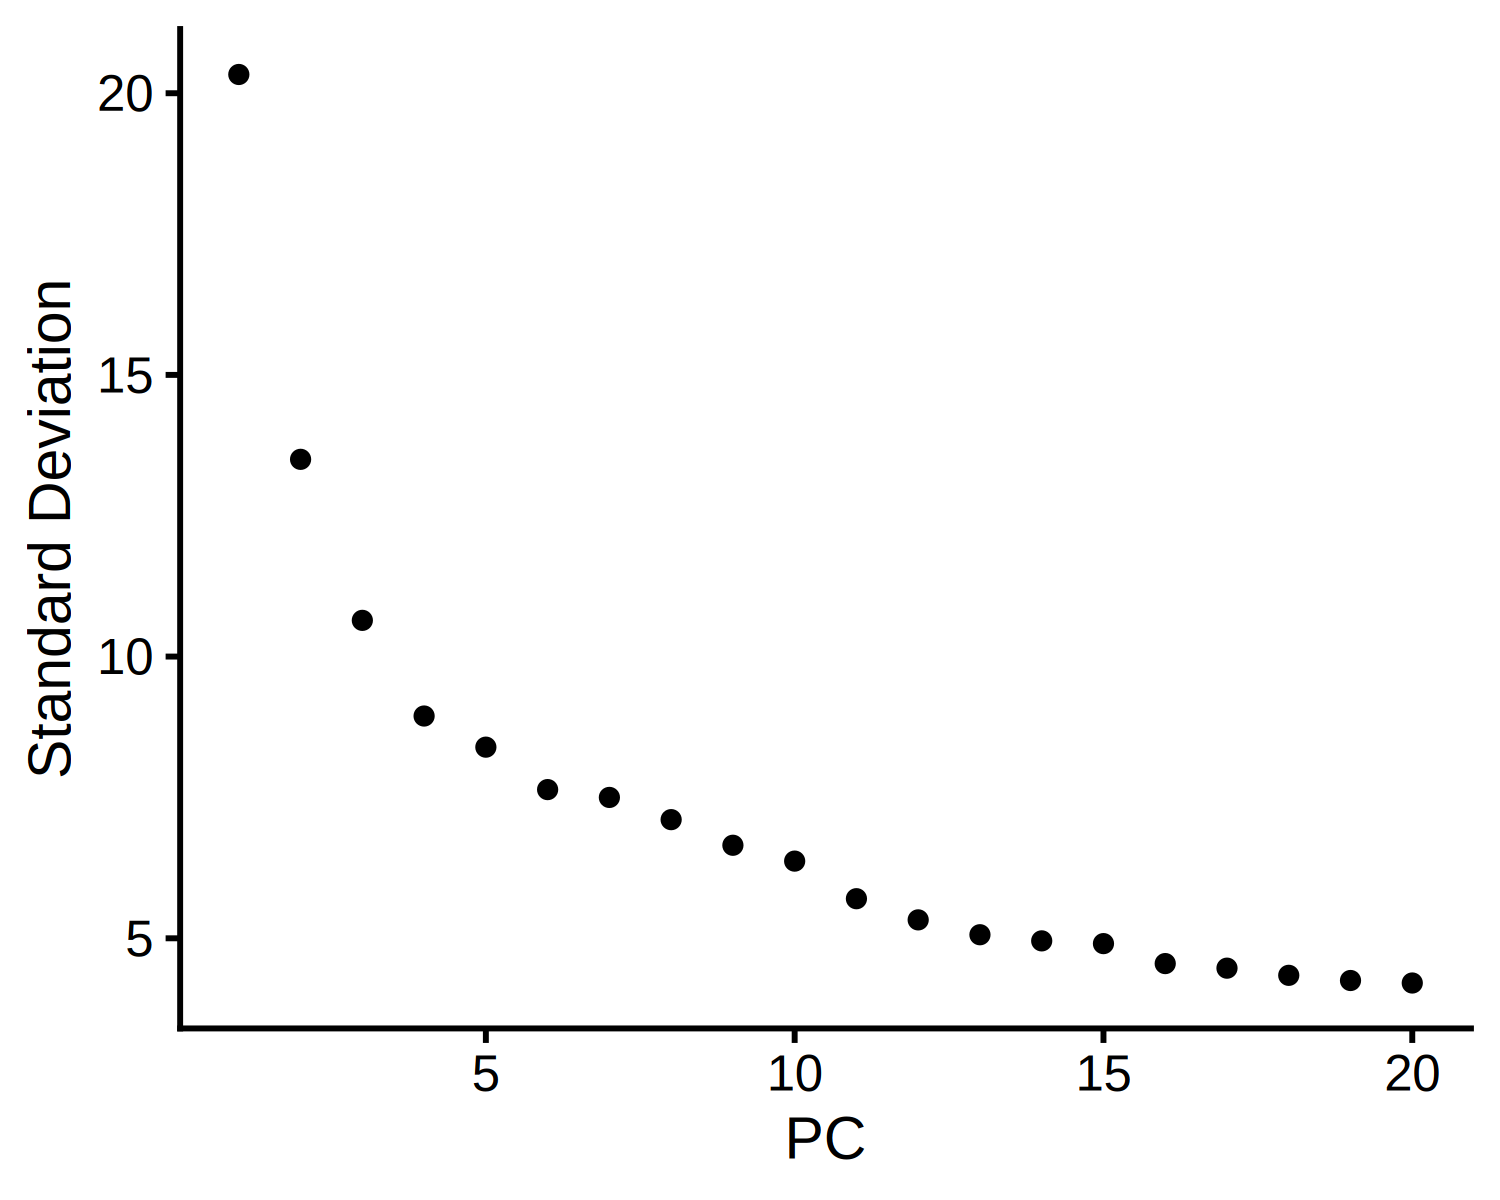

In [17]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
ElbowPlot(obj)

##  cell clustering 

In [18]:
obj

An object of class Seurat 
52115 features across 76089 samples within 2 assays 
Active assay: SCT (25518 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

In [19]:
obj <- AddMetaData(
  object = obj,
  metadata = stringr::str_split(row.names(obj@meta.data),"-",simplify=T)[,1],
  col.name = 'group'
)

obj <- AddMetaData(
  object = obj,
  metadata = stringr::str_split(row.names(obj@meta.data),"-",simplify=T)[,2],
  col.name = 'sex'
)

In [20]:
head(obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,group,sex
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA,Rat,2892,1519,0,3229,1519,iso,F
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG,Rat,2971,1489,0,3287,1489,iso,F
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG,Rat,1996,1189,0,3028,1208,iso,F
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT,Rat,5871,2496,0,4299,2456,iso,F
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG,Rat,2068,1185,0,3104,1190,iso,F
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT,Rat,1922,1121,0,3064,1153,iso,F


In [21]:
obj <- obj %>%
        FindNeighbors(reduction = "pca", dims = 1:15, verbose = FALSE) %>%
        FindClusters(resolution = 0.7, verbose = FALSE) %>%
        RunUMAP(reduction = "pca", dims = 1:15, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



In [22]:
obj

An object of class Seurat 
52115 features across 76089 samples within 2 assays 
Active assay: SCT (25518 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap